In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import pairwise_distances

# Final Project - Unveiling Consumer Insights: Behavior-Driven Segmentation with Machine Learning

In this project, we leveraged clustering and machine learning techniques to segment consumer purchasing patterns and try to predict their review ratings for specific purchases.

## Data Pre-processing

In [3]:
data_path_updated = 'shopping_behavior_updated.csv'
shopping_behavior = pd.read_csv(data_path_updated)

In [4]:
shopping_behavior.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [5]:
shopping_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [6]:
data = shopping_behavior.copy()
X = data.drop('Review Rating', axis=1)  
y = data['Review Rating']  # Used as labeled data to train the model

In [7]:
X_train, X_test_full, y_train, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42) 
# split the data into training and test sets

## EDA

Distribution in Gender:
Gender
Male      68.0
Female    32.0
Name: proportion, dtype: float64

Distribution in Item Purchased:
Item Purchased
Blouse        4.384615
Jewelry       4.384615
Pants         4.384615
Shirt         4.333333
Dress         4.256410
Sweater       4.205128
Jacket        4.179487
Belt          4.128205
Sunglasses    4.128205
Coat          4.128205
Sandals       4.102564
Socks         4.076923
Skirt         4.051282
Shorts        4.025641
Scarf         4.025641
Hat           3.948718
Handbag       3.923077
Hoodie        3.871795
Shoes         3.846154
T-shirt       3.769231
Sneakers      3.717949
Boots         3.692308
Backpack      3.666667
Gloves        3.589744
Jeans         3.179487
Name: proportion, dtype: float64

Distribution in Category:
Category
Clothing       44.538462
Accessories    31.794872
Footwear       15.358974
Outerwear       8.307692
Name: proportion, dtype: float64

Distribution in Location:
Location
Montana           2.461538
California        

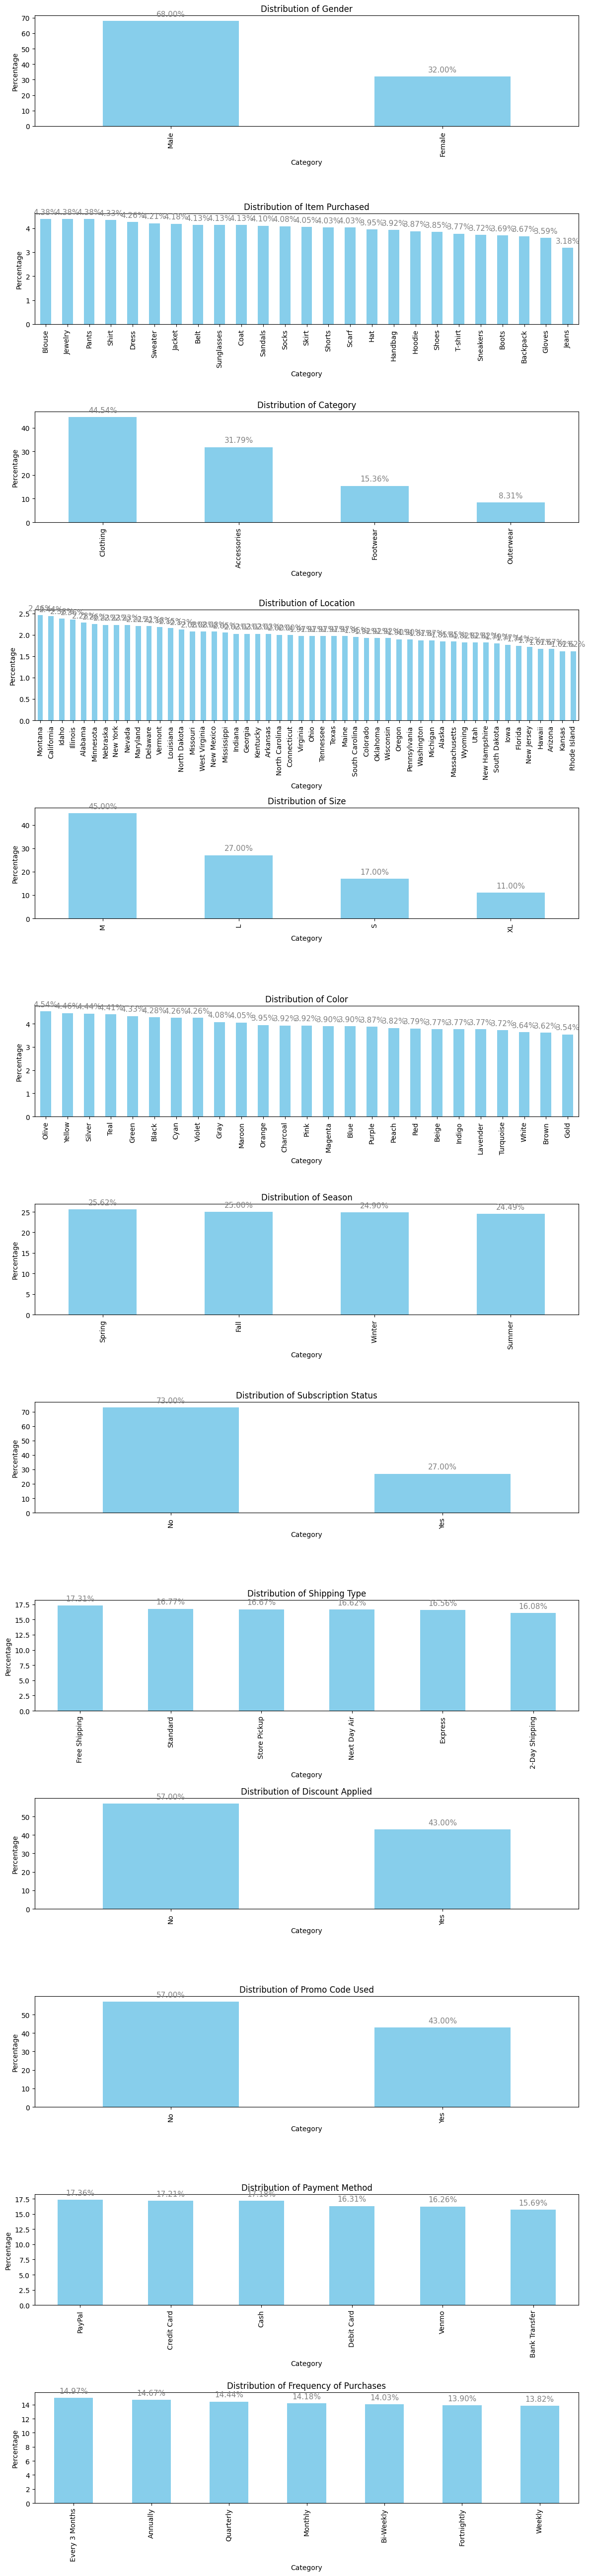

In [8]:
def check_balance(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    balance_data = {}
    
    for column in categorical_columns:
        distribution = df[column].value_counts(normalize=True) * 100
        balance_data[column] = distribution
    
    return balance_data

balance_data = check_balance(shopping_behavior)

for column, distribution in balance_data.items():
    print(f"Distribution in {column}:\n{distribution}\n")

fig, ax = plt.subplots(len(balance_data), 1, figsize=(12, 4 * len(balance_data)))

if len(balance_data) == 1:
    ax = [ax]

for i, (feature, values) in enumerate(balance_data.items()):
    values.plot(kind='bar', ax=ax[i], color='skyblue')
    ax[i].set_title(f'Distribution of {feature}')
    ax[i].set_ylabel('Percentage')
    ax[i].set_xlabel('Category')
    for p in ax[i].patches:
        ax[i].annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
                       textcoords='offset points')

plt.tight_layout()
plt.show()

/var/folders/dz/ykmlvvnx7gg2p91fhyn9gn600000gn/T/ipykernel_37299/4280465704.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Subscription Status', y='Review Rating', data=data, palette='Pastel1')


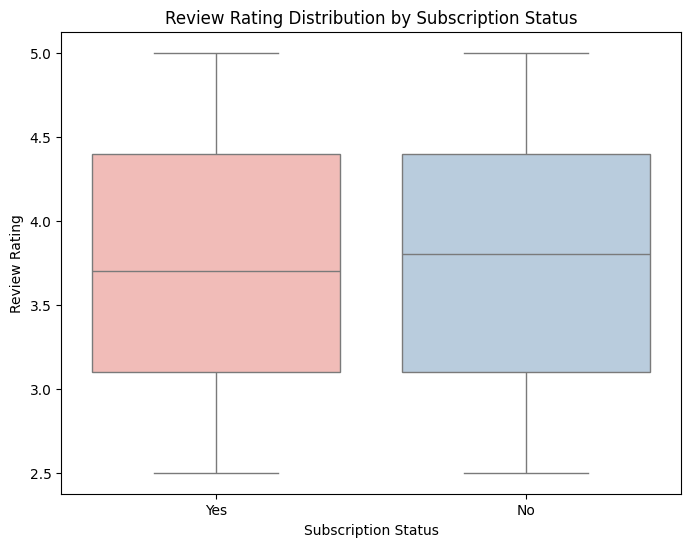

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Subscription Status', y='Review Rating', data=data, palette='Pastel1')
plt.title('Review Rating Distribution by Subscription Status')
plt.xlabel('Subscription Status')
plt.ylabel('Review Rating')
plt.show()

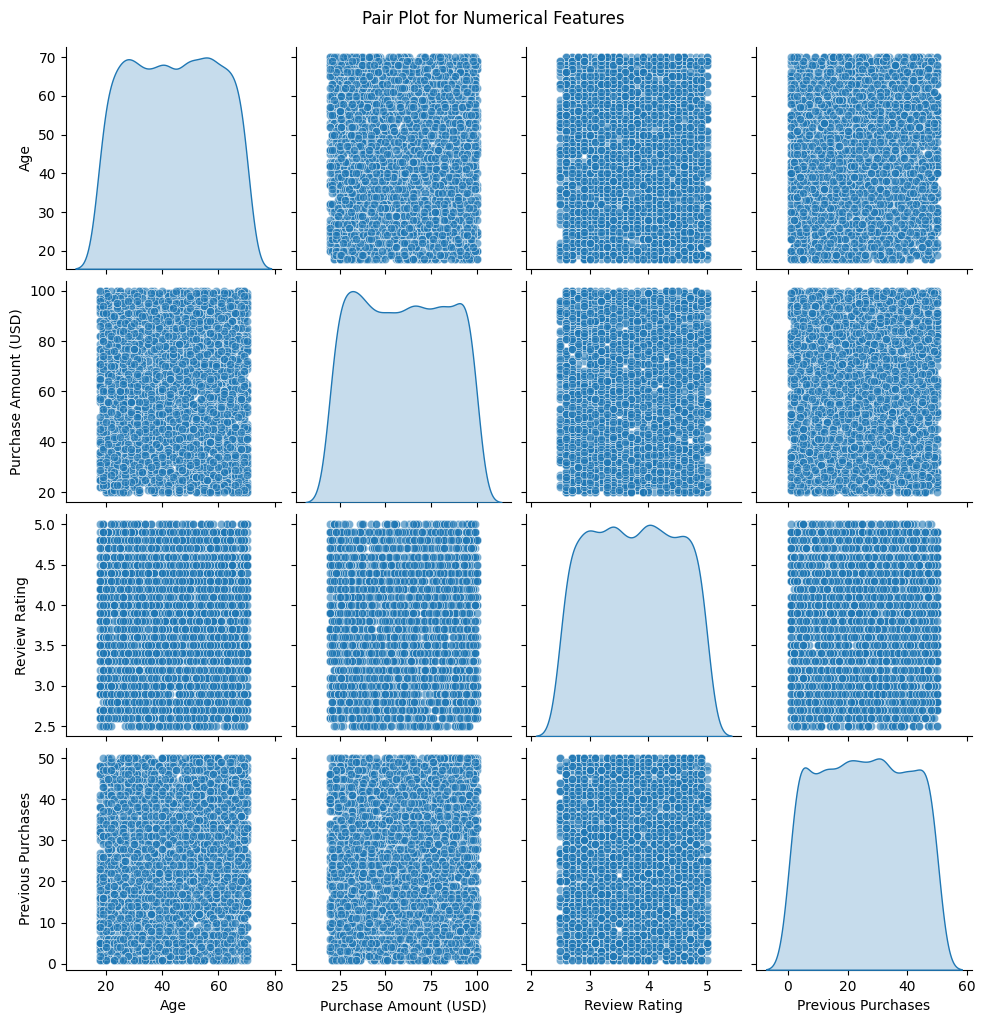

In [10]:
numerical_features = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']
sns.pairplot(data[numerical_features], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pair Plot for Numerical Features', y=1.02)
plt.show()

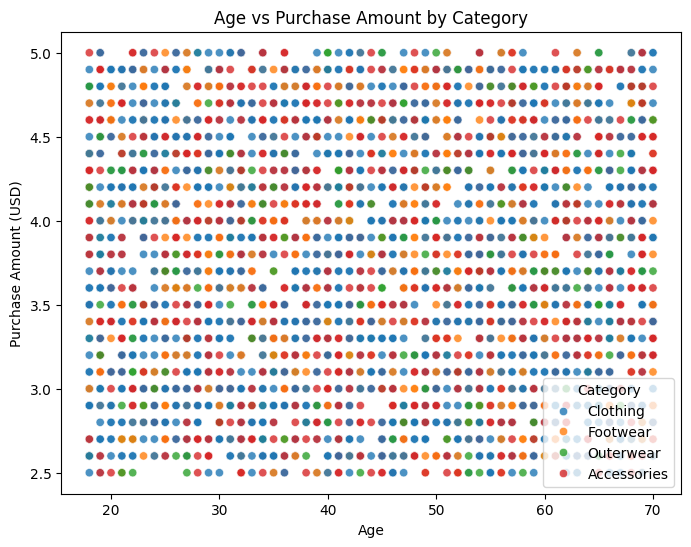

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age', y='Review Rating', hue='Category', data=data, palette='tab10', alpha=0.8)
plt.title('Age vs Purchase Amount by Category')
plt.xlabel('Age')
plt.ylabel('Purchase Amount (USD)')
plt.legend(title='Category')
plt.show()

The initial EDA for our project revealed limited distinctive patterns or relationships between the dataset's columns, making it challenging to derive meaningful insights. To address this, we adopted a clustering approach combined with PCA visualization as shown in the next section. By reducing the dataset's dimensionality using manual feature selections, we aimed to focus on the most significant features and assess whether the clustering results showed improved clarity and differentiation.

## Clustering

We would like to first divide consumers into different groups by testing out the best clustering strategy using manual feature selection and PCA visualization method. We will choose the best cluster number that yields the highest silhouette score and the cleanest PCA graph.

### Feature Selection

In [12]:
# Define which features to include for cluster
features_to_include = ['Gender', 'Item Purchased', 'Location', 'Subscription Status',  'Discount Applied', 'Frequency of Purchases', 'Shipping Type'
]
clustering_df = X_train[features_to_include]

# Define which features are categorical and which are numeric, end up only using the categorical features as they produce better sihlouette scores.
categorical_features_clustering = [
    'Gender', 'Item Purchased', 'Location', 'Subscription Status',  'Discount Applied', 'Frequency of Purchases', 'Shipping Type'
    #'Category', 
    # 'Location', 
    # 'Season', 
    # 'Subscription Status', 
    # 'Shipping Type', 
    # 'Discount Applied', 
    # 'Promo Code Used', 
    # 'Payment Method', 
    # 'Frequency of Purchases',
    # 'Color'
]
# numeric_features = ['Age'] 
# Not using age as it negatively affects sihlouette scores.

# Create a preprocessing pipeline for clustering
preprocessor_clustering = ColumnTransformer(
    transformers=[
        # ('num', StandardScaler(), numeric_features), 
        # Not needed because we are not including numeric features
        ('cat', OneHotEncoder(), categorical_features_clustering)
    ])

# Fit and transform the data
data_processed = preprocessor_clustering.fit_transform(X_train)
data_processed_dense = data_processed.toarray()  # Convert to dense array if needed

In [13]:
silhouette_scores = {}

### Spectral Clustering

Spectral clustering groups data using the eigenvalues of a similarity matrix, enabling effective clustering of non-convex shapes. It represents data as a graph, where nodes are points and edges capture pairwise similarities.

In [14]:
best_clusters_spectral = 0
best_score_spectral = -1

for n_clusters in range(3, 10):
    model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
    try:
        model.fit(data_processed_dense)
        cluster_labels = model.labels_  
        
        score = silhouette_score(data_processed_dense, cluster_labels, metric='euclidean')
        print(f"Silhouette Score for {n_clusters} clusters: {score}")
        
        if score > best_score_spectral:
            best_score_spectral = score
            best_clusters_spectral = n_clusters
    except ValueError as e:
        print(f"Unable to calculate silhouette score for {n_clusters} clusters. Error: {e}")

print(f"Best silhouette score: {best_score_spectral} achieved with {best_clusters_spectral} clusters.")

Silhouette Score for 3 clusters: 0.11856796026336949
Silhouette Score for 4 clusters: 0.11536242141200455
Silhouette Score for 5 clusters: 0.09028860728648751
Silhouette Score for 6 clusters: 0.06693087971362591
Silhouette Score for 7 clusters: 0.06561444230495195
Silhouette Score for 8 clusters: 0.07007664314025919
Silhouette Score for 9 clusters: 0.0660554255962852
Best silhouette score: 0.11856796026336949 achieved with 3 clusters.


In [ ]:
# Spectral Clustering
n_clusters = 4  
# Although the best score is achieved with 3 clusters, we will use 4 clusters due to the cluster pattern on the PCA visualization

spectral_model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
clusters_spectral = spectral_model.fit_predict(data_processed_dense)

clustering_df['Spectral Cluster'] = clusters_spectral

silhouette_scores['Spectral'] = silhouette_score(data_processed_dense, clusters_spectral)

/var/folders/dz/ykmlvvnx7gg2p91fhyn9gn600000gn/T/ipykernel_37299/691617822.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_df['Spectral Cluster'] = clusters_spectral


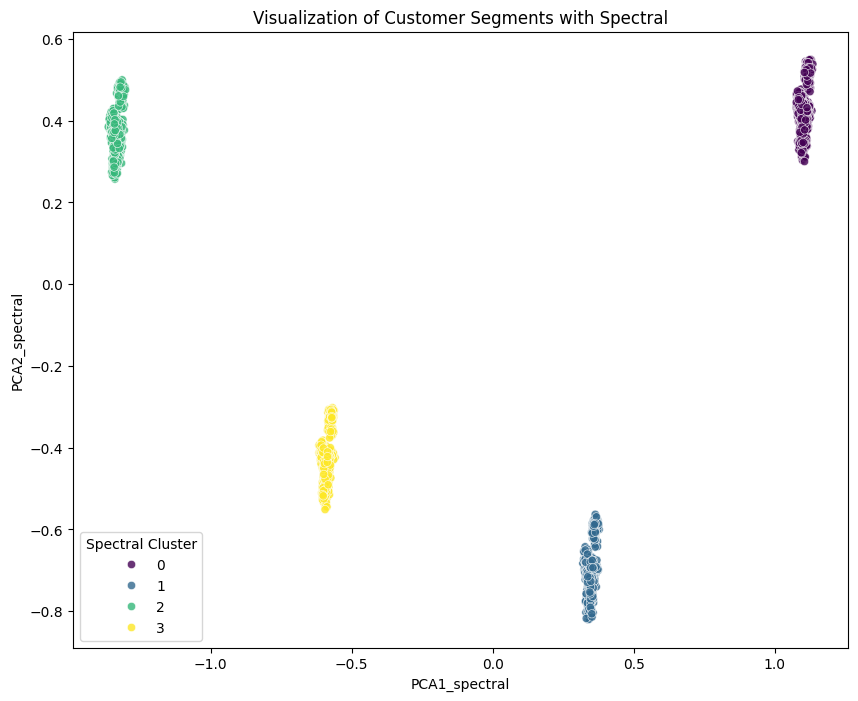

In [41]:
pca_spectral = PCA(n_components=2) # 2 principal components to find the most significant features
principal_components_spectral = pca_spectral.fit_transform(data_processed_dense)
clustering_df['PCA1_spectral'] = principal_components_spectral[:,0]
clustering_df['PCA2_spectral'] = principal_components_spectral[:,1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1_spectral', y='PCA2_spectral', hue='Spectral Cluster', data=clustering_df, palette='viridis', alpha=0.8)
plt.title('Visualization of Customer Segments with Spectral')
plt.show()

### GMM (Gaussian Mixture Models)

Gaussian Mixture Models are probabilistic models that represent data as a mixture of multiple Gaussian distributions. It estimates the parameters using the Expectation-Maximization (EM) algorithm, making it effective for clustering and density estimation.

In [17]:
best_clusters_gmm = 0
best_score_gmm = -1

for n_clusters in range(3, 10):
    model = GaussianMixture(n_components=n_clusters, random_state=42)
    
    try:
        cluster_labels = model.fit_predict(data_processed_dense)
        
        score = silhouette_score(data_processed_dense, cluster_labels, metric='euclidean')
        print(f"Silhouette Score for {n_clusters} clusters: {score}")
        
        if score > best_score_gmm:
            best_score_gmm = score
            best_clusters_gmm = n_clusters
    except ValueError as e:
        print(f"Unable to calculate silhouette score for {n_clusters} clusters. Error: {e}")

print(f"Best silhouette score: {best_score_gmm} achieved with {best_clusters_gmm} clusters.")

Silhouette Score for 3 clusters: 0.11163018769030679
Silhouette Score for 4 clusters: 0.11536242141200455
Silhouette Score for 5 clusters: 0.09249414856202119
Silhouette Score for 6 clusters: 0.06739383807469622
Silhouette Score for 7 clusters: 0.04552278507552709
Silhouette Score for 8 clusters: 0.05994204157026492
Silhouette Score for 9 clusters: 0.0581760223744724
Best silhouette score: 0.11536242141200455 achieved with 4 clusters.


In [18]:
# Gaussian Mixture Model
n_components = 4  

gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(data_processed_dense)

clusters_gmm = gmm.predict(data_processed_dense)
clustering_df['GMM Cluster'] = clusters_gmm

silhouette_scores['Gaussian Mixture'] = silhouette_score(data_processed_dense, clusters_gmm)

/var/folders/dz/ykmlvvnx7gg2p91fhyn9gn600000gn/T/ipykernel_37299/1496671277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_df['GMM Cluster'] = clusters_gmm


/var/folders/dz/ykmlvvnx7gg2p91fhyn9gn600000gn/T/ipykernel_37299/1788520475.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_df['PCA1_gmm'] = principal_components_gmm[:,0]
/var/folders/dz/ykmlvvnx7gg2p91fhyn9gn600000gn/T/ipykernel_37299/1788520475.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_df['PCA2_gmm'] = principal_components_gmm[:,1]


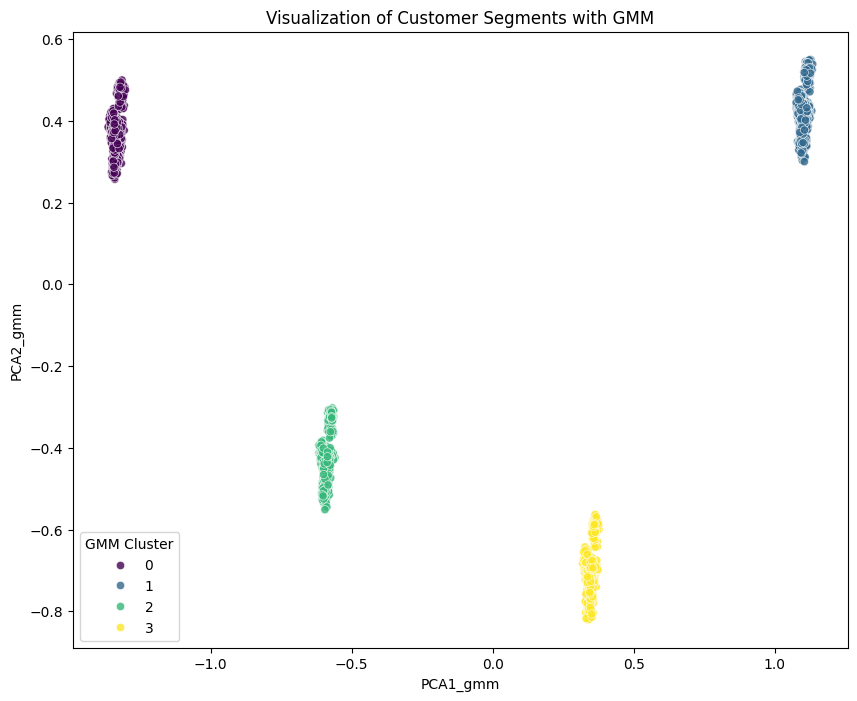

In [ ]:
pca_gmm = PCA(n_components=2)
principal_components_gmm = pca_gmm.fit_transform(data_processed_dense)
clustering_df['PCA1_gmm'] = principal_components_gmm[:,0]
clustering_df['PCA2_gmm'] = principal_components_gmm[:,1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1_gmm', y='PCA2_gmm', hue='GMM Cluster', data=clustering_df, palette='viridis', alpha=0.8)
plt.title('Visualization of Customer Segments with GMM')
plt.show()

### KMeans

KMeans clustering partitions data into k groups by minimizing the variance within clusters. It assigns points to the nearest cluster centroid and iteratively updates centroids to optimize grouping.

In [20]:
best_clusters_kmeans = 0
best_score_kmeans = -1

for n_clusters in range(3, 10): 
    model = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = model.fit_predict(data_processed_dense)
    
    try:
        score = silhouette_score(data_processed_dense, cluster_labels, metric='euclidean')
        print(f"Silhouette Score for {n_clusters} clusters: {score}")
        
        if score > best_score_kmeans:
            best_score_kmeans = score
            best_clusters_kmeans = n_clusters
    except ValueError as e:
        print(f"Unable to calculate silhouette score for {n_clusters} clusters. Error: {e}")

print(f"Best silhouette score: {best_score_kmeans} achieved with {best_clusters_kmeans} clusters.")

Silhouette Score for 3 clusters: 0.11163018769030679
Silhouette Score for 4 clusters: 0.11536242141200455
Silhouette Score for 5 clusters: 0.09348081297075768
Silhouette Score for 6 clusters: 0.06888598149303135
Silhouette Score for 7 clusters: 0.04915880894303383
Silhouette Score for 8 clusters: 0.06116531214040212
Silhouette Score for 9 clusters: 0.06259447667128624
Best silhouette score: 0.11536242141200455 achieved with 4 clusters.


In [21]:
# Kmeans
n_clusters = 4  

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data_processed_dense)
clusters_kmeans = kmeans.labels_

clustering_df['KMeans Cluster'] = clusters_kmeans

silhouette_scores['KMeans'] = silhouette_score(data_processed_dense, clusters_kmeans)

/var/folders/dz/ykmlvvnx7gg2p91fhyn9gn600000gn/T/ipykernel_37299/2313998840.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_df['KMeans Cluster'] = clusters_kmeans


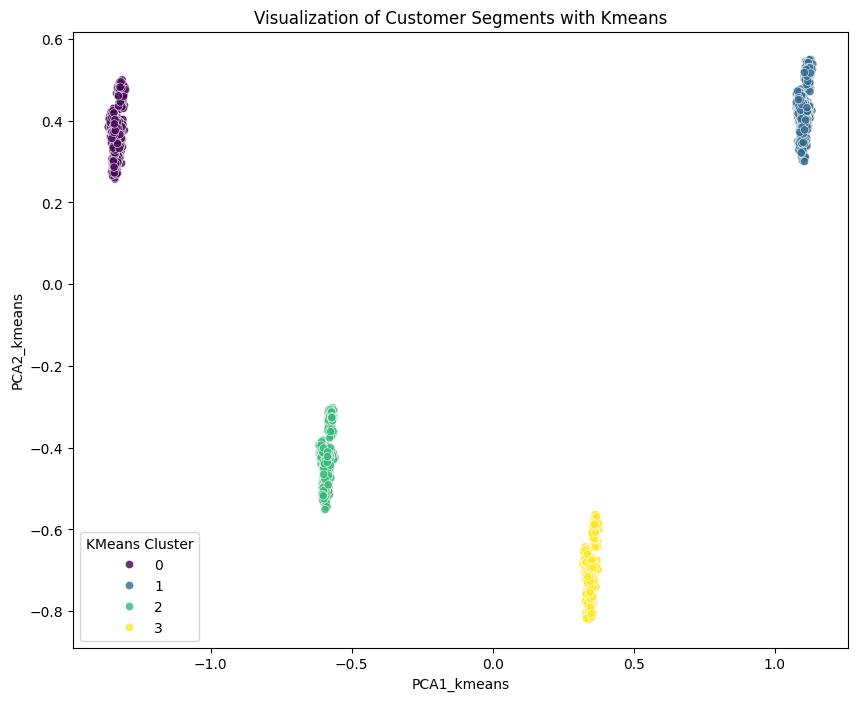

In [43]:
pca_kmeans = PCA(n_components=2) # 2 principal components to find the most significant features
principal_components_kmeans = pca_kmeans.fit_transform(data_processed_dense)
clustering_df['PCA1_kmeans'] = principal_components_kmeans[:,0]
clustering_df['PCA2_kmeans'] = principal_components_kmeans[:,1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1_kmeans', y='PCA2_kmeans', hue='KMeans Cluster', data=clustering_df, palette='viridis', alpha=0.8)
plt.title('Visualization of Customer Segments with Kmeans')
plt.show()

### Agglomerative Clustering

Agglomerative clustering is a hierarchical method that builds clusters by successively merging the closest pairs of data points or clusters. It starts with each point as its own cluster and continues until all points are in a single cluster.

In [23]:
best_clusters_agg = 0
best_score_agg = -1

for n_clusters in range(3, 10): 
    model = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = model.fit_predict(data_processed_dense)
    
    try:
        score = silhouette_score(data_processed_dense, cluster_labels, metric='euclidean')
        print(f"Silhouette Score for {n_clusters} clusters: {score}")
        
        if score > best_clusters_agg:
            best_score_agg = score
            best_clusters_agg = n_clusters
    except ValueError as e:
        print(f"Unable to calculate silhouette score for {n_clusters} clusters. Error: {e}")

print(f"Best silhouette score: {best_score_agg} achieved with {best_clusters_agg} clusters.")

Silhouette Score for 3 clusters: 0.11210700968110543
Silhouette Score for 4 clusters: 0.10592370847129838
Silhouette Score for 5 clusters: 0.07783313580717213
Silhouette Score for 6 clusters: 0.07729255137204274
Silhouette Score for 7 clusters: 0.06624381535035581
Silhouette Score for 8 clusters: 0.04283623542408006
Silhouette Score for 9 clusters: 0.04201770320776973
Best silhouette score: 0.11210700968110543 achieved with 3 clusters.


In [24]:
# Agglomerative Clustering
n_clusters = 4  
# Same reason as with Spectral

agg = AgglomerativeClustering(n_clusters=n_clusters)
agg.fit(data_processed_dense)

clusters_agg = agg.labels_

clustering_df['Agg Cluster'] = clusters_agg

silhouette_scores['Agglomerative'] = silhouette_score(data_processed_dense, clusters_agg)

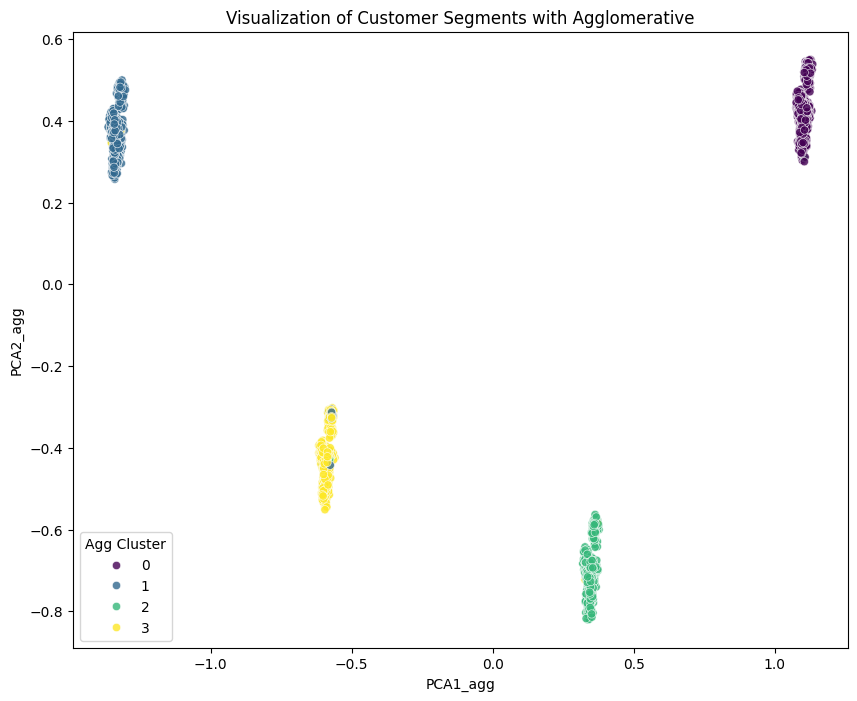

In [42]:
pca_agg = PCA(n_components=2) # 2 principal components to find the most significant features
principal_components_agg = pca_agg.fit_transform(data_processed_dense)
clustering_df['PCA1_agg'] = principal_components_agg[:,0]
clustering_df['PCA2_agg'] = principal_components_agg[:,1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1_agg', y='PCA2_agg', hue='Agg Cluster', data=clustering_df, palette='viridis', alpha=0.8)
plt.title('Visualization of Customer Segments with Agglomerative')
plt.show()

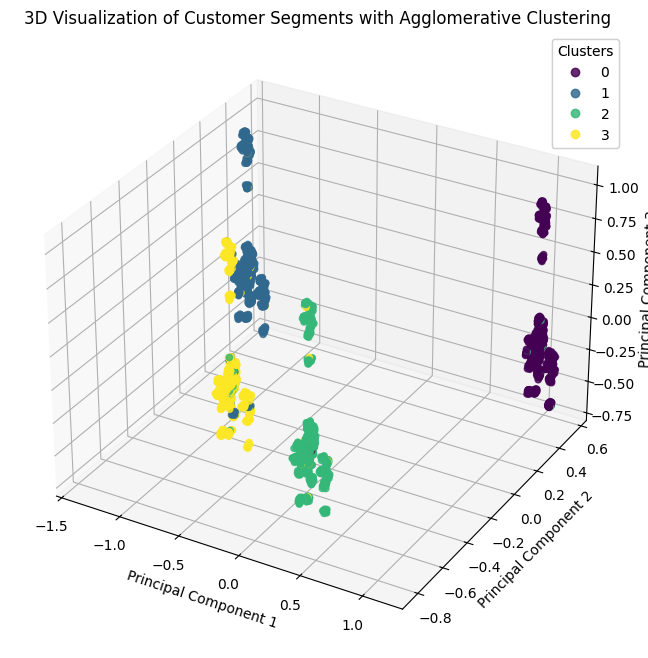

In [26]:
# 3D Visualization of Customer Segments with Agglomerative Clustering with 3 Principal Components
pca_agg_3D = PCA(n_components=3)
principal_components_agg_3D = pca_agg_3D.fit_transform(data_processed_dense)
clustering_df['PCA1_agg_3D'] = principal_components_agg_3D[:,0]
clustering_df['PCA2_agg_3D'] = principal_components_agg_3D[:,1]
clustering_df['PCA3_agg_3D'] = principal_components_agg_3D[:,2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(clustering_df['PCA1_agg_3D'], clustering_df['PCA2_agg_3D'], clustering_df['PCA3_agg_3D'], 
                     c=clustering_df['Agg Cluster'], cmap='viridis', alpha=0.8)

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Visualization of Customer Segments with Agglomerative Clustering')

plt.show()

### Clustering Model Selection

In [27]:
df_scores = pd.DataFrame(list(silhouette_scores.items()), columns=['Clustering Method', 'Silhouette Score'])
print(df_scores)

  Clustering Method  Silhouette Score
0          Spectral          0.115362
1  Gaussian Mixture          0.115362
2            KMeans          0.115362
3     Agglomerative          0.105924


#### **Spectral Clustering, Gaussian Mixture Model, and KMeans are the best performing clustering methods in our dataset, we will choose Gaussian Mixture Model in this project.**

The result turned out to be quite satisfying as clear cluster patterns can be observed using PCA visualizations, we then move on to the next section, which is building and applying the predictive model that we built to predict consumer rating for each sector.

## Predictive Model Building

In this section, we apply the predictive models—Random Forest Regressor, Artificial Neural Network (ANN), Support Vector Regressor (SVR), and Gradient Boosting—to each cluster identified in the previous section, rather than the entire dataset. This cluster-specific modeling approach, inspired by the work of Trivedi S, Pardos Z A et al. [1], aims to enhance prediction accuracy by tailoring models to the unique characteristics of each cluster. Finally, we select the model that minimizes the loss for predicting consumer ratings within each cluster.

### Feature Selection & Engineering

In [28]:
# Feature select the features we want to include for modelling (different from those used for clustering)
features_to_include = ['Age', 'Gender', 'Item Purchased', 'Location', 'Subscription Status',
                       'Discount Applied', 'Frequency of Purchases', 'Shipping Type',
                       'Season', 'Payment Method', 'Color', 'Promo Code Used']
target_variable = 'Review Rating'

categorical_features_predictive = ['Gender', 'Item Purchased', 'Location', 'Subscription Status',
                        'Discount Applied', 'Frequency of Purchases', 'Shipping Type', 
                        'Season', 'Payment Method', 'Color', 'Promo Code Used']
numeric_features_predictive = ['Age']

# Use pipelines of OneHotEncoder and StandardScaler to preprocess the data
categorical_preprocessor_predictive = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor_predictive = ColumnTransformer(transformers=[
    ('cat', categorical_preprocessor_predictive, categorical_features_predictive),
    ('num', StandardScaler(), numeric_features_predictive)
])

# Fit and transform the data
data_processed = preprocessor_predictive.fit_transform(X_train.copy())

# Get feature names from OneHotEncoder
cat_one_hot_features = list(preprocessor_predictive.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features_predictive))
all_features = cat_one_hot_features + numeric_features_predictive  # Combine categorical and numeric feature names

# Resetting index before merging or assigning
train_predictive = pd.DataFrame(data_processed.toarray(), columns=all_features)
train_predictive.reset_index(drop=True, inplace=True)
clustering_df.reset_index(drop=True, inplace=True)  
y.reset_index(drop=True, inplace=True)
train_predictive[target_variable] = y
train_predictive['Cluster'] = clustering_df['GMM Cluster']
train_predictive

,Gender_Male,Item Purchased_Belt,Item Purchased_Blouse,Item Purchased_Boots,Item Purchased_Coat,Item Purchased_Dress,Item Purchased_Gloves,Item Purchased_Handbag,Item Purchased_Hat,Item Purchased_Hoodie,...,Color_Silver,Color_Teal,Color_Turquoise,Color_Violet,Color_White,Color_Yellow,Promo Code Used_Yes,Age,Review Rating,Cluster
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.989151,3.1,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.265845,3.1,3
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.443789,3.1,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.646702,3.5,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.917748,2.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.509544,4.1,2
3116,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.120661,3.7,2
3117,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.186416,3.0,0
3118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.128686,4.7,1


### Random Forest Regressor

Random Forest Regressor is an ensemble learning method that combines multiple decision trees to improve prediction accuracy. It aggregates predictions from individual trees by averaging, reducing overfitting and improving generalization. 

In [29]:
models_rf = {}
cluster_scores_rf = {}

for cluster in train_predictive['Cluster'].unique(): # Loop through each cluster
    # Filter data for the current cluster
    cluster_data = train_predictive[train_predictive['Cluster'] == cluster]
    X_train, X_test, y_train, y_test = train_test_split(
        cluster_data.drop(['Review Rating', 'Cluster'], axis=1), 
        cluster_data['Review Rating'], test_size=0.2, random_state=42
    )
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    score = root_mean_squared_error(y_test, predictions)
    
    models_rf[cluster] = model
    cluster_scores_rf[cluster] = score

    print(f"Cluster {cluster}: RMSE = {score}")

Cluster 0: RMSE = 0.7341170916084278
Cluster 3: RMSE = 0.7588458803101552
Cluster 1: RMSE = 0.7438212348486462
Cluster 2: RMSE = 0.7412296319946594


In [30]:
# Search for the best parameters using GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
best_rmse_rf = np.sqrt(-grid_search_rf.best_score_)
print("Best parameters for RandomForestRegressor:", best_params_rf)
print("Best RMSE for RandomForestRegressor:", best_rmse_rf)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_

### ANN (Artificial Neural Networks)

Artificial Neural Networks are computational models inspired by the human brain, consisting of interconnected layers of nodes (neurons). They learn patterns by adjusting weights through backpropagation, making them effective for complex tasks like regression and predicting consumer review ratings. There are too many hyper-parameters for artificial neural network to be tuned, thus we used the method manual tuning instead of a GridSearchCV.

In [31]:
models_ann = {}
cluster_scores_ann = {}

for cluster in train_predictive['Cluster'].unique(): # Loop through each cluster
    # Filter data for the current cluster
    cluster_data = train_predictive[train_predictive['Cluster'] == cluster]
    X_train, X_test, y_train, y_test = train_test_split(
        cluster_data.drop(['Review Rating', 'Cluster'], axis=1), 
        cluster_data['Review Rating'], test_size=0.2, random_state=42
    )
    
    # Define the ANN model with its dense layers, dropout layers, and the final output layer.
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  
        Dropout(0.6),
        Dense(64, activation='relu'),
        Dropout(0.6),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=SGD(learning_rate=0.01), loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)  
    predictions = model.predict(X_test)
    score = root_mean_squared_error(y_test, predictions)
    
    models_ann[cluster] = model
    cluster_scores_ann[cluster] = score
    
    print(f"Cluster {cluster}: RMSE = {score}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Cluster 0: RMSE = 0.6990631517108253


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Cluster 3: RMSE = 0.7547897918716816


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Cluster 1: RMSE = 0.712165901261562


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Cluster 2: RMSE = 0.7037583085882502


### SVR (Support Vector Regression)

SVR (Support Vector Regression) is a regression model derived from the Support Vector Machine (SVM) framework, commonly used for classification tasks. It is designed to predict a continuous output while maintaining the principles of SVM, so it is especially suited in the use of predicting user ratings.

In [32]:
models_svr = {}
cluster_scores_svr = {}

# Loop over each cluster to create and train an SVR model
for cluster in train_predictive['Cluster'].unique():
    # Filter data for the current cluster
    cluster_data = train_predictive[train_predictive['Cluster'] == cluster]
    X_train, X_test, y_train, y_test = train_test_split(
        cluster_data.drop(['Review Rating', 'Cluster'], axis=1), 
        cluster_data['Review Rating'], test_size=0.2, random_state=42
    )
    
    # Define the SVR model
    model = SVR(C=1, epsilon=1, gamma=1, kernel='rbf') 
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    score = root_mean_squared_error(y_test, predictions) 
    
    # Store the model and its score
    models_svr[cluster] = model
    cluster_scores_svr[cluster] = score
    
    print(f"Cluster {cluster}: RMSE = {score}")

Cluster 0: RMSE = 0.6864914150146856
Cluster 3: RMSE = 0.7260384453923092
Cluster 1: RMSE = 0.7066111018480843
Cluster 2: RMSE = 0.7054394447907362


In [33]:
# Search for the best parameters using GridSearchCV
param_grid_svr = {
    'C': [0.1, 1, 10, 100],  
    'gamma': ['scale', 'auto', 0.01, 0.1, 1], 
    'kernel': ['rbf', 'linear', 'poly'], 
    'epsilon': [0.01, 0.1, 0.5, 1]  
}

model = SVR()

grid_search = GridSearchCV(model, param_grid_svr, cv=5, scoring='neg_mean_squared_error', verbose=2)

best_model_svr = grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.01, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......C=0.1, epsilon=0.01, gamma=sca

### Gradient Boosting Regressor

The Gradient Boosting Regressor is a machine learning model designed specifically for regression tasks where the target variable is continuous. It belongs to the ensemble learning family, combining multiple weak learners (typically decision trees) to create a strong predictive model. Different from Random Forest that builds decision trees independently and in parallel, gradient boosting builds trees sequentially, where each tree corrects the residual errors of its predecessor. It uses boosting to iteratively improve the model.

In [34]:
models_gb = {}
cluster_scores_gb = {}

for cluster in train_predictive['Cluster'].unique(): # Loop through each cluster
    # Filter data for the current cluster
    cluster_data = train_predictive[train_predictive['Cluster'] == cluster]
    X_train, X_test, y_train, y_test = train_test_split(
        cluster_data.drop(['Review Rating', 'Cluster'], axis=1), 
        cluster_data['Review Rating'], test_size=0.2, random_state=42
    )
    
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    score = root_mean_squared_error(y_test, predictions) 
    
    models_gb[cluster] = model
    cluster_scores_gb[cluster] = score
    
    print(f"Cluster {cluster}: RMSE = {score}")

Cluster 0: RMSE = 0.7262170246721539
Cluster 3: RMSE = 0.7759524072706337
Cluster 1: RMSE = 0.7479485497895757
Cluster 2: RMSE = 0.7463667182815045


In [35]:
# Search for the best parameters using GridSearchCV
param_grid_gb = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [3, 4, 5], 
    'min_samples_split': [2, 4], 
    'min_samples_leaf': [1, 2],  
    'subsample': [0.8, 0.9, 1.0]  
}

best_models_gb = {}

model = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(model, param_grid_gb, cv=5, scoring='neg_mean_squared_error', verbose=2)

best_models_gb = grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time

### Ensemble Method

In [36]:
# Ensemble the models together and choose the best model with the lowest RMSE for each cluster
def create_ann_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.6),
        Dense(64, activation='relu'),
        Dropout(0.6),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

cluster_models = {}
cluster_performances = {}

for cluster in train_predictive['Cluster'].unique():
    X = train_predictive[train_predictive['Cluster'] == cluster].drop(['Review Rating', 'Cluster'], axis=1)
    y = train_predictive[train_predictive['Cluster'] == cluster]['Review Rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        'random_forest': RandomForestRegressor(max_depth=20, max_features='log2', min_samples_leaf=4, min_samples_split=10, n_estimators=50, random_state=42),
        'gradient_boosting': GradientBoostingRegressor(learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0, random_state=42),
        'svr': SVR(C=100, epsilon=1, gamma='auto', kernel='poly'),
        'ann': create_ann_model(X_train.shape[1])
    }

    performances = {}
    for name, model in models.items():
        if name == 'ann':
            model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
        else:
            model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, predictions)
        performances[name] = rmse

    cluster_models[cluster] = models
    cluster_performances[cluster] = performances

    best_model_name = min(performances, key=performances.get)
    print(f"Best model for cluster {cluster} is {best_model_name} with RMSE: {performances[best_model_name]}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Best model for cluster 0 is gradient_boosting with RMSE: 0.6879763078481433


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Best model for cluster 3 is svr with RMSE: 0.7241342731911623


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Best model for cluster 1 is svr with RMSE: 0.7075874400117222


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Best model for cluster 2 is svr with RMSE: 0.703564978468325


In [37]:
# Output the best model for each cluster
best_models_per_cluster = {}

for cluster in train_predictive['Cluster'].unique():
    performances = cluster_performances[cluster]
    best_model_name = min(performances, key=performances.get)  
    best_model = cluster_models[cluster][best_model_name]  
    best_models_per_cluster[cluster] = best_model 
    print(f"Best model for cluster {cluster} is {best_model_name} with RMSE: {performances[best_model_name]}")

Best model for cluster 0 is gradient_boosting with RMSE: 0.6879763078481433
Best model for cluster 3 is svr with RMSE: 0.7241342731911623
Best model for cluster 1 is svr with RMSE: 0.7075874400117222
Best model for cluster 2 is svr with RMSE: 0.703564978468325


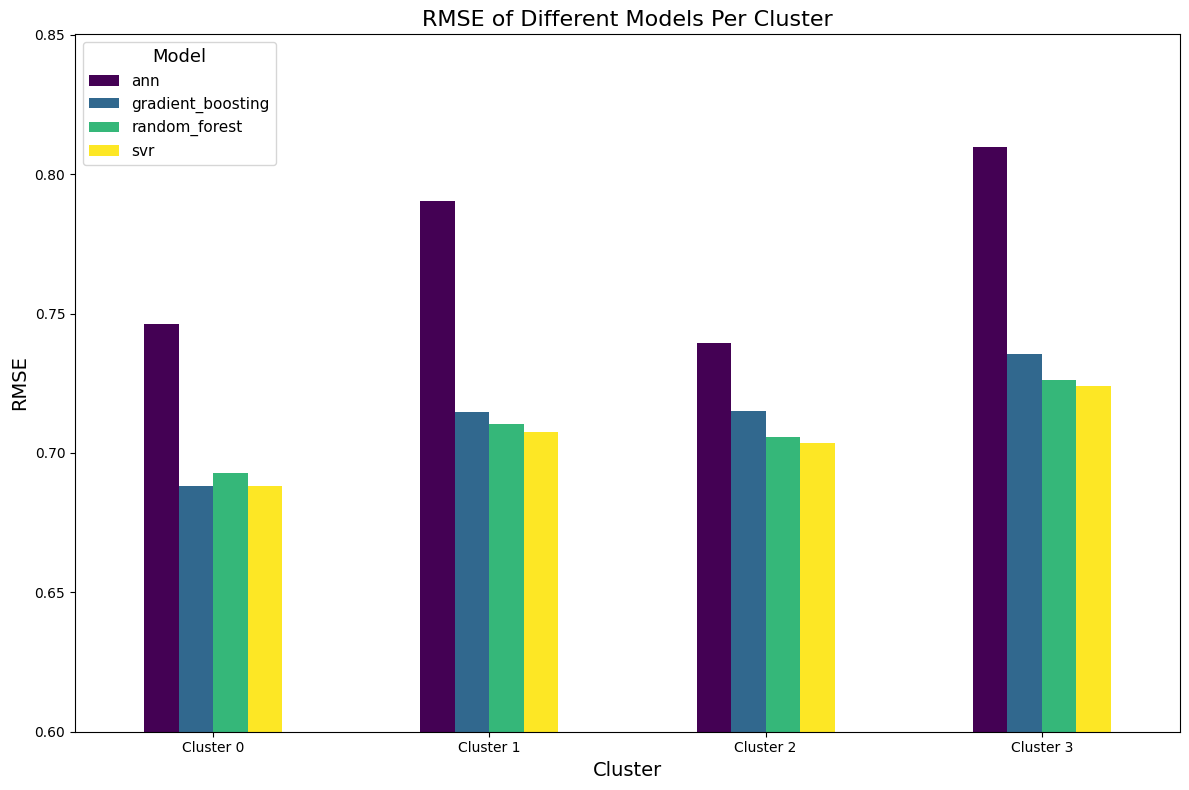

In [38]:
# Visualize the RMSE of different models per cluster
clusters = []
models = []
rmses = []

for cluster_id, model_performances in cluster_performances.items():
    for model_name, rmse in model_performances.items():
        clusters.append(f"Cluster {cluster_id}")
        models.append(model_name)
        rmses.append(rmse)

df = pd.DataFrame({
    'Cluster': clusters,
    'Model': models,
    'RMSE': rmses
})

pivot_df = df.pivot_table(index="Cluster", columns="Model", values="RMSE", aggfunc='mean')

fig, ax = plt.subplots(figsize=(12, 8))
pivot_df.plot(kind='bar', ax=ax, colormap='viridis')
ax.set_title('RMSE of Different Models Per Cluster', fontsize=16)
ax.set_xlabel('Cluster', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.set_xticks(range(len(pivot_df.index)))
ax.set_xticklabels(pivot_df.index, rotation=0)
ax.legend(title='Model', title_fontsize='13', fontsize=11)
ax.set_ylim(0.6, pivot_df.values.max() * 1.05)  

plt.tight_layout()
plt.show()

### Testing

In [39]:
# Define the features to include and the preprocessing steps
features_to_include_test = ['Age', 'Gender', 'Item Purchased', 'Location', 'Subscription Status',
                            'Discount Applied', 'Frequency of Purchases', 'Shipping Type',
                            'Season', 'Payment Method', 'Color', 'Promo Code Used']
target_variable_test = 'Review Rating'

categorical_features_test = ['Gender', 'Item Purchased', 'Location', 'Subscription Status',
                             'Discount Applied', 'Frequency of Purchases', 'Shipping Type', 
                             'Season', 'Payment Method', 'Color', 'Promo Code Used']
numeric_features_test = ['Age']

# Setup preprocessing pipelines for categorical and numeric data
categorical_preprocessor_test = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor_test = ColumnTransformer(transformers=[
    ('cat', categorical_preprocessor_test, categorical_features_test),
    ('num', StandardScaler(), numeric_features_test)
])

# Fit and transform the test data
data_processed_test = preprocessor_test.fit_transform(X_test_full[features_to_include_test])

# Get feature names from onehot and combine with numeric feature names
cat_one_hot_features_test = list(preprocessor_test.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features_test))
all_features_test = cat_one_hot_features_test + numeric_features_test

# Create df with the processed test data
test_predictive = pd.DataFrame(data_processed_test.toarray(), columns=all_features_test)
test_predictive.reset_index(drop=True, inplace=True)

# Display the processed test df
test_predictive

,Gender_Male,Item Purchased_Belt,Item Purchased_Blouse,Item Purchased_Boots,Item Purchased_Coat,Item Purchased_Dress,Item Purchased_Gloves,Item Purchased_Handbag,Item Purchased_Hat,Item Purchased_Hoodie,...,Color_Purple,Color_Red,Color_Silver,Color_Teal,Color_Turquoise,Color_Violet,Color_White,Color_Yellow,Promo Code Used_Yes,Age
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.252006
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.998323
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.208641
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.502335
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.317813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.120393
776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537675
777,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.844267
778,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.327357


In [40]:
# Predict user ratings using the best model for each cluster and use test set to evaluate the model.
def predict_new_entries(models, centroids, test_data):
    # Calculate distances from each test entry to each cluster centroid
    distances = pairwise_distances(centroids, test_data, metric='euclidean')
    
    # Find the index of the closest cluster for each test entry
    closest_clusters = np.argmin(distances, axis=0)
    
    # Predict using the model of the closest cluster for each test entry
    predictions = np.array([models[cluster].predict(test_data.iloc[[i]])[0] for i, cluster in enumerate(closest_clusters)])
    
    return predictions

centroids = train_predictive.groupby('Cluster').mean()
predictions = predict_new_entries(best_models_per_cluster, centroids.drop(['Review Rating'], axis=1), test_predictive)
rmse = root_mean_squared_error(y_test_full, predictions)
print(f"Test RMSE: {rmse}")

Test RMSE: 0.7377532687493987


## Conclusion

This project is aiming towards segmentation of consumer behavior and predict their review ratings. We have utilized various models like random forest, gradient boosting, SVR, and ANN to tailor our prediction to specific consumer clusters. The final test RMSE of 0.738 indicates a good prediction accuracy.  
Our project illustrates the potential of tailored models across different consumer segments and sets the stage for more personalized and dynamic consumer interaction strategies in the future.

## References

- https://www.wikipedia.org/

- Trivedi, S., Pardos, Z. A., Sarkozy, G. N., & Heffernan, N. T. (2012). Co-clustering by bipartite spectral graph partitioning for out-of-tutor prediction. *International Educational Data Mining Society.*